In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 KB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 13.9 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=c260d41471f3db6ae0d10e2dc1b300de6d9ce683581bfde8041dac9e596bf85d
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [1]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
import csv



2023-01-18 15:18:37.915736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 15:18:39.945097: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-18 15:18:40.565945: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-18 15:18:40.565973: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Data Generator

In [2]:
class CSVDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, csv_path, batch_size, timesteps, split_sequences):
        self.csv_path = csv_path
        self.timesteps = timesteps
        self.batch_size = batch_size + timesteps
        self.split_sequences = split_sequences

    def __len__(self):
        with open(self.csv_path) as f:
            num_rows = sum(1 for _ in f)
        return int(np.ceil(num_rows / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_data = []
        with open(self.csv_path, newline='') as csvfile:
            csvreader = csv.reader(csvfile)
            next(csvreader) # if the file contains headers
            for i, row in enumerate(csvreader):
                if i >= idx * self.batch_size and i < (idx + 1) * self.batch_size:
                    batch_data.append(list(map(float, row)))
                if i >= (idx + 1) * self.batch_size:
                    break
        return self.split_sequences(batch_data, self.timesteps)

def split_sequences_batch_wise(batch_data, n_steps):
    input_data = []
    output_data = []
    for i in range(len(batch_data)):
        end_ix = i + n_steps
        if end_ix > len(batch_data) - 1:
            break

        # gather input and output parts of the pattern
        seq_x = batch_data[i:end_ix]
        seq_y = batch_data[end_ix][:1]
        input_data.append(seq_x)
        output_data.append(seq_y)
    return np.array(input_data), np.array(output_data)
  
ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit/'
def get_data_generator(cid, batch_size, timesteps, type):
      #path = f'{ROOT_PATH}cross-silo/site_{cid}/{type}.csv'
      #path = f'{ROOT_PATH}cross-silo/complete_dataset2.csv'
      #path = f'{ROOT_PATH}building_{cid}/{type}.csv'
      building = os.listdir('/content/drive/MyDrive/Colab Notebooks/Masterarbeit/local_training')[int(cid)]
      path = f'{ROOT_PATH}/local_training/{building}/{type}.csv'
      return CSVDataGenerator(path, batch_size, timesteps, split_sequences_batch_wise)

### Model definition

In [ ]:
features = 12
timesteps = 3
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(50, activation="relu", input_shape=(timesteps,12)))
model.add(tf.keras.layers.RepeatVector(timesteps))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(loss='mse',optimizer='adam', metrics=['mae'])


In [ ]:
BATCH_SIZE = 128 
TIMESTEPS = 3
CID = 1070
train = get_data_generator(CID,BATCH_SIZE,TIMESTEPS,"train")
val = get_data_generator(CID,BATCH_SIZE,TIMESTEPS,"val")
test = get_data_generator(CID,BATCH_SIZE,TIMESTEPS,"test")

## lokales Training

In [3]:
def get_building_ids(root_dir: str, bid: str):
    """Returns a list of building ids"""
    
    site_dir = os.path.join(root_dir, f'building_{bid}')
    #site_files = os.listdir(site_dir)
    #site_files = [os.path.join(site_dir, file) for file in os.listdir(site_dir)]
    return site_dir
  


In [4]:
def get_data_generator(cid, sid, batch_size, timesteps, type):
      #path = f'{ROOT_PATH}cross-silo/site_{cid}/{type}.csv'
      #path = f'{ROOT_PATH}cross-silo/complete_dataset2.csv'
      #path = f'{ROOT_PATH}building_{cid}/{type}.csv'
      building = os.listdir(f'/home/azureuser/masterarbeit/ready_datasets/site_{sid}')[int(cid)]
      path = f'/home/azureuser/masterarbeit/ready_datasets/site_{sid}/{building}/{type}.csv'
      return CSVDataGenerator(path, batch_size, timesteps, split_sequences_batch_wise)

In [ ]:
os.listdir(f'/content/drive/MyDrive/Colab Notebooks/Masterarbeit/local_training_complete/site_{0}')[int(12)]

'building_15'

In [5]:
def train_model(id):
  """wandb.init(project="test-run2", entity="adrian-ziegler", group=f"Local Models {SITE_ID}", config={
  "learning_rate": 0.001,
  "epochs": 30,
  "batch_size": 128,
  "architecture": "Autoencoder",
  "n_steps": 3,
  "n_features": 12,
  "building_id" : id
})"""
  features = 12
  timesteps = 3
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(50, activation="relu", input_shape=(timesteps,12)))
  model.add(tf.keras.layers.RepeatVector(timesteps))
  model.add(tf.keras.layers.LSTM(50, return_sequences=False))
  model.add(tf.keras.layers.Dense(100, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model.compile(loss='mse',optimizer='adam', metrics=['mae'])

  BATCH_SIZE = 128 
  TIMESTEPS = 3
  CID = id
  train = get_data_generator(id,SITE_ID,BATCH_SIZE,TIMESTEPS,"train")
  val = get_data_generator(id,SITE_ID,BATCH_SIZE,TIMESTEPS,"val")
  test = get_data_generator(id,SITE_ID,BATCH_SIZE,TIMESTEPS,"test")
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
  with tf.device('/device:GPU:0'):
    history = model.fit(train, validation_data=val, validation_steps = 5, epochs=50, callbacks=[callback], verbose=1)
  return model, pd.DataFrame(history.history)

In [ ]:
get_data_generator(98,0, 128,3,"test")

In [7]:
#jetzt alles zusammen:
#output = pd.DataFrame(columns=['building_id', 'MAE', 'MAPE', 'Epochen'])
def predict_and_save_results(id, model, df, train_history):
  building = os.listdir(f'/home/azureuser/masterarbeit/ready_datasets/site_{SITE_ID}')[int(id)]
  #building_id = str.split(building, '_')[1]
  output = df
  BATCH_SIZE = 128
  test = get_data_generator(id,SITE_ID, BATCH_SIZE,TIMESTEPS,"test")
  result = model.predict(test)
  g = []
  for i in range(len(test)):
    g.append(test[i][1])
  ground_truth = np.concatenate(g, axis=0)
  error = abs(np.expm1(result) - np.expm1(ground_truth))
  error_percent = (error/np.expm1(result)*100)
  MAE = error.mean()
  MAPE = error_percent.mean()
  MSE = np.square(np.subtract(np.expm1(result),np.expm1(ground_truth))).mean()
  RMSE = np.sqrt(MSE)
  results = pd.DataFrame([{'building_id': building, 'MAE': MAE,'MAPE':MAPE, 'MSE': MSE, 'RMSE': RMSE, 'Epochen': len(train_history)}])
  output = pd.concat([output,results], ignore_index=True)
  #wandb.finish()
  return output

In [ ]:
timesteps = 3
model, re = train_model("98")

In [20]:
import pandas as pd
pd.read_csv("complete_train.csv").astype('float64').to_csv("complete_train.csv", index=False, header=False)

In [19]:
pd.read_csv("complete_val.csv").astype('float64').to_csv("complete_val.csv", index=False, header=False)

In [21]:
pd.read_csv("complete_test.csv").astype('float64').to_csv("complete_test.csv", index=False, header=False)

In [8]:
timesteps = 3
BATCH_SIZE = 128 
TIMESTEPS = 3
SITE_ID = 4
output = pd.DataFrame(columns=['building_id', 'MAE', 'MAPE', 'MSE', 'RMSE', 'Epochen'])
n_buildings = len(os.listdir(f'/home/azureuser/masterarbeit/ready_datasets/site_{SITE_ID}'))
for i in range(n_buildings):
  current_model, h = train_model(i)
  print(f'{i}-te Runde von {n_buildings} vorbei.')
  output = predict_and_save_results(i,current_model, output, h)
output.to_csv(f'/home/azureuser/masterarbeit/site_{SITE_ID}.csv')

Epoch 1/50
54/54 [==============================] - 5s 32ms/step - loss: 0.9251 - mae: 0.7104 - val_loss: 0.0684 - val_mae: 0.2090
Epoch 2/50
54/54 [==============================] - 1s 23ms/step - loss: 0.0367 - mae: 0.1526 - val_loss: 0.0409 - val_mae: 0.1571
Epoch 3/50
54/54 [==============================] - 1s 21ms/step - loss: 0.0310 - mae: 0.1381 - val_loss: 0.0336 - val_mae: 0.1450
Epoch 4/50
54/54 [==============================] - 1s 20ms/step - loss: 0.0283 - mae: 0.1308 - val_loss: 0.0361 - val_mae: 0.1482
Epoch 5/50
54/54 [==============================] - 1s 20ms/step - loss: 0.0260 - mae: 0.1237 - val_loss: 0.0301 - val_mae: 0.1355
Epoch 6/50
54/54 [==============================] - 1s 20ms/step - loss: 0.0237 - mae: 0.1178 - val_loss: 0.0264 - val_mae: 0.1297
Epoch 7/50
54/54 [==============================] - 1s 20ms/step - loss: 0.0219 - mae: 0.1124 - val_loss: 0.0243 - val_mae: 0.1230
Epoch 8/50
54/54 [==============================] - 1s 22ms/step - loss: 0.0205 - m

In [ ]:
timesteps = 3
BATCH_SIZE = 128
TIMESTEPS = 3
SITE_ID = 2
output = pd.DataFrame(columns=['building_id', 'MAE', 'MAPE', 'MSE', 'RMSE', 'Epochen'])
n_buildings = len(os.listdir(f'/content/drive/MyDrive/Colab Notebooks/Masterarbeit/local_training_complete/site_{SITE_ID}'))
for i in range(n_buildings):
  current_model, h = train_model(i)
  output = predict_and_save_results(i,current_model, output, h)
  print(f'{i}-te Runde von {n_buildings} vorbei.')
output.to_csv(f'/content/drive/MyDrive/Colab Notebooks/Masterarbeit/results_local_training/site_{SITE_ID}.csv')

NotADirectoryError: ignored

In [ ]:
building = os.listdir(f'/content/drive/MyDrive/Colab Notebooks/Masterarbeit/local_training_complete/site_{SITE_ID}')[int(3)]
building_id = str.split(building, '_')[1]
print(building_id)

In [ ]:
test = get_data_generator(98,0, 128,3,"test")

7/7 [==============================] - 1s 8ms/step


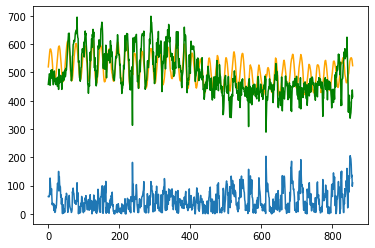

In [ ]:
import matplotlib.pyplot as plt
result = model.predict(test)
g = []
for i in range(len(test)):
  g.append(test[i][1])
ground_truth = np.concatenate(g, axis=0)
error = abs(np.expm1(result) - np.expm1(ground_truth))
error_percent = (error/np.expm1(result)*100)
MAE = error.mean()
MAPE = error_percent.mean()
MSE = np.square(np.subtract(np.expm1(result),np.expm1(ground_truth))).mean()
RMSE = np.sqrt(MSE)
fig, ax = plt.subplots()
ax.plot(error)
ax.plot(np.expm1(result), color="orange", label="prediction")
ax.plot(np.expm1(ground_truth), color="green", label="truth")
#ax.plot(MAPE)

In [ ]:
sum(result-ground_truth)/len(ground_truth)

array([2.7861841])

## zentrales Training


In [ ]:
def get_data_generator(cid,sid, batch_size, timesteps, type):
      path = f'{ROOT_PATH}cross-silo/site_{sid}/{type}.csv'
      #path = f'{ROOT_PATH}cross-silo/complete_dataset2.csv'
      #path = f'{ROOT_PATH}building_{cid}/{type}.csv'
      #building = os.listdir(f'/content/drive/MyDrive/Colab Notebooks/Masterarbeit/local_training_complete/site_{sid}')[int(cid)]
      #path = f'{ROOT_PATH}/local_training_complete/site_{sid}/{building}/{type}.csv'
      return CSVDataGenerator(path, batch_size, timesteps, split_sequences_batch_wise)

In [ ]:
def train_model():
  """wandb.init(project="test-run2", entity="adrian-ziegler", name=f"Central Model {SITE_ID}", config={
  "learning_rate": 0.001,
  "epochs": 30,
  "batch_size": 128,
  "architecture": "Autoencoder",
  "n_steps": 3,
  "n_features": 12,
  })"""
  features = 12
  timesteps = 3
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(50, activation="relu", input_shape=(timesteps,12)))
  model.add(tf.keras.layers.RepeatVector(timesteps))
  model.add(tf.keras.layers.LSTM(50, return_sequences=False))
  model.add(tf.keras.layers.Dense(100, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model.compile(loss='mse',optimizer='adam', metrics=['mae'])

  BATCH_SIZE = 128 
  TIMESTEPS = 3
  CID = id
  train = get_data_generator(CID,SITE_ID,BATCH_SIZE,TIMESTEPS,"train")
  val = get_data_generator(CID,SITE_ID,BATCH_SIZE,TIMESTEPS,"val")
  test = get_data_generator(CID,SITE_ID,BATCH_SIZE,TIMESTEPS,"test")
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
  with tf.device('/device:GPU:0'):
    history = model.fit(train, validation_data=val, validation_steps = 5, epochs=20, verbose=1, callbacks=[callback])#, WandbCallback()], )
  return model, pd.DataFrame(history.history)

In [ ]:
!wandb login

In [ ]:
#jetzt alles zusammen:
#output = pd.DataFrame(columns=['building_id', 'MAE', 'MAPE', 'Epochen'])
def predict_and_save_results(id, model, df, train_history):
  #building = os.listdir(f'/content/drive/MyDrive/Colab Notebooks/Masterarbeit/local_training_complete/site_{SITE_ID}')[int(id)]
  #building_id = str.split(building, '_')[1]
  output = df
  BATCH_SIZE = 128
  test = get_data_generator(id,SITE_ID, BATCH_SIZE,TIMESTEPS,"test")
  result = model.predict(test)
  g = []
  for i in range(len(test)):
    g.append(test[i][1])
  ground_truth = np.concatenate(g, axis=0)
  error = abs(np.expm1(result) - np.expm1(ground_truth))
  error_percent = (error/np.expm1(result)*100)
  MAE = error.mean()
  MAPE = error_percent.mean()
  MSE = np.square(np.subtract(np.expm1(result),np.expm1(ground_truth))).mean()
  RMSE = np.sqrt(MSE)
  results = pd.DataFrame([{'site_id': SITE_ID, 'MAE': MAE,'MAPE':MAPE, 'MSE': MSE, 'RMSE': RMSE, 'Epochen': len(train_history)}])
  output = pd.concat([output,results], ignore_index=True)
  wandb.finish()
  return output

In [ ]:
timesteps = 3
BATCH_SIZE = 128
TIMESTEPS = 3
SITE_ID = 13
output = pd.DataFrame(columns=['site_id', 'MAE', 'MAPE', 'MSE', 'RMSE', 'Epochen'])
current_model, h = train_model()
output = predict_and_save_results(i,current_model, output, h)
#print(f'{i}-te Runde von {n_buildings} vorbei.')
output.to_csv(f'/content/drive/MyDrive/Colab Notebooks/Masterarbeit/results_silo_training/site_{SITE_ID}.csv')
current_model.save(f'/content/drive/MyDrive/Colab Notebooks/Masterarbeit/results_silo_training/model_weights{SITE_ID}.h5', save_format='h5')

Epoch 1/20
6839/7564 [==========================>...] - ETA: 22:47 - loss: 0.0735 - mae: 0.1119